# Classification Task: Predicting Tax Avoidance Categories

**ML2 Course - Extra Points Assignment (5 points)**

---

## Task Overview

In the original project, we predicted **continuous ETR values** (regression). Your task is to convert this into a **classification problem** by categorizing companies into **tax avoidance risk levels**.

**Target Variable Transformation:**
- **Low Tax Avoidance** (Class 0): ETR > 0.25 (companies paying relatively high taxes)
- **Medium Tax Avoidance** (Class 1): 0.15 < ETR ≤ 0.25
- **High Tax Avoidance** (Class 2): ETR ≤ 0.15 (companies with aggressive tax optimization)

---

## Instructions

### Part 1: Data Preparation (1 point)
1. Load the prepared datasets (`train_fe.csv` and `test_fe.csv`)
2. Create the target classification variable based on ETR thresholds above
3. Check class balance and visualize the distribution
4. Select features (use existing feature engineering from the project)

### Part 2: Model Training (1.5 points)
Train and evaluate **THREE** classification models:
1. **Logistic Regression** (multiclass)
2. **K-Nearest Neighbors Classifier**
3. **Support Vector Classifier (SVC)**

For each model:
- Perform hyperparameter tuning (use GridSearchCV or similar)
- Use proper cross-validation strategy for time-series data
- Evaluate on training set using CV

### Part 3: Final Evaluation (0.5 points)
1. Select the best model based on validation performance
2. Evaluate on the test set using:
   - **Accuracy**
   - **Precision, Recall, F1-Score** (for each class)
   - **Confusion Matrix**
3. Compare results across all three models
4. Provide brief interpretation (2-3 sentences)

---

## Evaluation Metrics

Primary metric: **Macro F1-Score** (equally weights all classes)

Secondary metrics: Accuracy, Confusion Matrix

---

## Submission Requirements

- Complete this notebook with code and outputs
- Save best model(s) as pickle files in `models/` directory
- Commit and push to your GitHub repository
- Send repository link to: **mj.wozniak9@uw.edu.pl**

**Deadline:** [To be announced by instructor]

---

Good luck! 🚀


In [18]:
# 1. Imports and configuration
# -----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42

# Directories for input/output
DATA_DIR = Path("../data/output")
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)


In [20]:
# 2. Helper functions and target creation
# ---------------------------------------
def make_target(etr_series):
    """
    Convert Effective Tax Rate (ETR) into three discrete classes.
    This approach follows the professor's hint to discretize continuous
    ETR values into meaningful business-oriented categories:
        0 = Low tax avoidance (ETR > 0.25)
        1 = Medium (0.15 < ETR <= 0.25)
        2 = High (ETR <= 0.15)
    """
    etr = etr_series.copy()
    target = pd.Series(index=etr.index, dtype=int)
    target[etr > 0.25] = 0
    target[(etr > 0.15) & (etr <= 0.25)] = 1
    target[etr <= 0.15] = 2
    return target.astype(int)


def check_columns(df, col='etr'):
    """Ensure the required ETR column exists."""
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in dataset.")


def plot_normalized_confusion(y_true, y_pred, labels=None, title=None):
    """Visualize performance as normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, values_format='.2f')
    if title:
        plt.title(title)
    plt.show()

In [22]:
# 3. Load input datasets
# ----------------------
train = pd.read_csv(DATA_DIR / 'train_fe.csv')
test = pd.read_csv(DATA_DIR / 'test_fe.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (3993, 116)
Test shape: (363, 116)


In [24]:
# 4. Target generation and preprocessing
# ---------------------------------------
# Convert ETR into classification target if not already available
if 'target' not in train.columns:
    check_columns(train, 'etr')
    train['target'] = make_target(train['etr'])

if 'target' not in test.columns:
    check_columns(test, 'etr')
    test['target'] = make_target(test['etr'])

# Remove metadata columns that do not carry predictive information
possible_meta = ['id', 'company', 'year', 'date', 'ETR', 'etr']
exclude = [c for c in possible_meta if c in train.columns]
features = [c for c in train.columns if c not in exclude + ['target']]
print('Number of candidate features:', len(features))

# Split into feature matrix and target vector
X_train = train[features].copy()
y_train = train['target'].copy()
X_test = test[features].copy()
y_test = test['target'].copy()

print('\nTrain class counts:\n', y_train.value_counts())
print('\nTest class counts:\n', y_test.value_counts())


Number of candidate features: 115

Train class counts:
 target
1    1668
0    1267
2    1058
Name: count, dtype: int64

Test class counts:
 target
1    195
0    103
2     65
Name: count, dtype: int64


In [26]:
# 5. Boruta feature selection integration
# ---------------------------------------------------
# Using the precomputed Boruta ranking ensures consistency with prior work.
# This step replaces Sequential Feature Selection entirely.
N_TOP_FEATURES = 20
fr_path = DATA_DIR / "feature_ranking.xlsx"

if fr_path.exists():
    fr = pd.read_excel(fr_path)
    possible_cols = [c.lower() for c in fr.columns]
    if 'boruta_rank' in possible_cols:
        rank_col = fr.columns[possible_cols.index('boruta_rank')]
        fr_sorted = fr.sort_values(by=rank_col, ascending=True)
    else:
        fr_sorted = fr.copy()

    feat_col = fr.columns[0] if 'feature' not in possible_cols else fr.columns[possible_cols.index('feature')]
    top_features = fr_sorted[feat_col].head(N_TOP_FEATURES).tolist()
    print(f" Using top {len(top_features)} Boruta-ranked features:\n", top_features[:10], "...")
    X_train = X_train[top_features].copy()
    X_test = X_test[top_features].copy()
else:
    print(" feature_ranking.xlsx not found — using all numeric features instead.")

# Keep only numeric columns
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]
print("Numeric features retained:", X_train.shape[1])


 Using top 20 Boruta-ranked features:
 ['etr_y_past', 'WB_GDPpc', 'txt', 'diff', 'etr_y_ma', 'diff_ma', 'dlc_cat_(176.129, 200.9]', 'pi', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]'] ...
Numeric features retained: 20


In [28]:
# 6. Time-based cross-validation
# ---------------------------------------------------
# TimeSeriesSplit ensures model validation respects temporal ordering,
# preventing lookahead bias and ensuring realistic performance estimation.
tscv = TimeSeriesSplit(n_splits=3)
# ---------------------------------------------------
# 7. Define models and GridSearch parameters
# ---------------------------------------------------
# Chosen models balance interpretability and performance.
# Each grid is compact to reduce runtime but still tests meaningful ranges.
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        multi_class='multinomial', solver='saga',
        max_iter=3000, random_state=RANDOM_STATE))
])
param_grid_lr = {'clf__C': [0.01, 0.1, 1, 10]}

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance']
}

pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, random_state=RANDOM_STATE))
])
param_grid_svc = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

models_for_search = {
    'LogisticRegression': (pipe_lr, param_grid_lr),
    'KNN': (pipe_knn, param_grid_knn),
    'SVC': (pipe_svc, param_grid_svc)
}



Using TimeSeriesSplit with 3 folds


In [30]:
# 8. GridSearchCV optimization
# ---------------------------------------------------
# GridSearchCV is systematic, reproducible, and integrates naturally
# with TimeSeriesSplit, making it ideal for time-dependent data.
results = {}
scoring = 'f1_macro'

for name, (pipeline, grid) in models_for_search.items():
    print(f"\nRunning GridSearchCV for {name}")
    gs = GridSearchCV(
        pipeline, grid,
        scoring=scoring, cv=tscv,
        n_jobs=-1, verbose=1
    )
    gs.fit(X_train, y_train)
    print('Best params:', gs.best_params_)
    print('Best CV score:', gs.best_score_)
    results[name] = gs
    joblib.dump(gs.best_estimator_, MODELS_DIR / f'{name}_best.pkl')
    pd.DataFrame(gs.cv_results_).to_csv(MODELS_DIR / f'{name}_cv_results.csv', index=False)



 Running GridSearchCV for LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 0.1}
Best CV score: 0.5760247751561435

 Running GridSearchCV for KNN
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__n_neighbors': 9, 'clf__weights': 'distance'}
Best CV score: 0.5944308480599242

 Running GridSearchCV for SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 1, 'clf__kernel': 'rbf'}
Best CV score: 0.6176952752048592



LogisticRegression - Test Accuracy: 0.6061 - Test F1_macro: 0.5664
              precision    recall  f1-score   support

         Low     0.5565    0.6214    0.5872       103
      Medium     0.7095    0.6513    0.6791       195
        High     0.4203    0.4462    0.4328        65

    accuracy                         0.6061       363
   macro avg     0.5621    0.5729    0.5664       363
weighted avg     0.6143    0.6061    0.6089       363



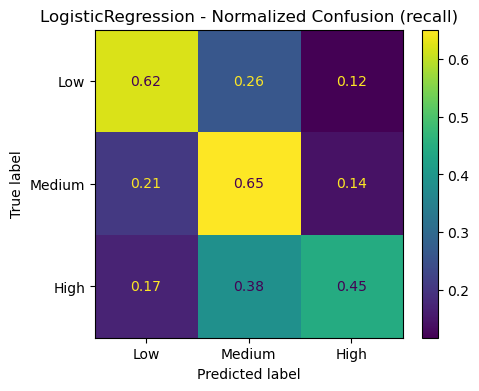


KNN - Test Accuracy: 0.6061 - Test F1_macro: 0.5752
              precision    recall  f1-score   support

         Low     0.5962    0.6019    0.5990       103
      Medium     0.7086    0.6359    0.6703       195
        High     0.4048    0.5231    0.4564        65

    accuracy                         0.6061       363
   macro avg     0.5698    0.5870    0.5752       363
weighted avg     0.6223    0.6061    0.6118       363



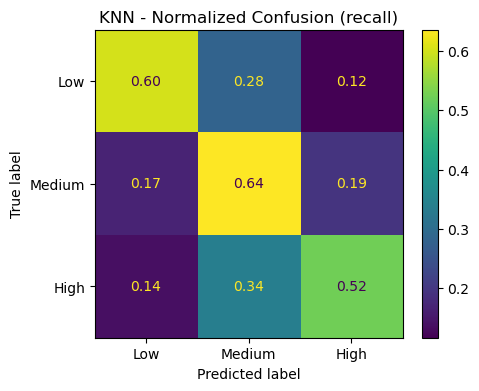


SVC - Test Accuracy: 0.6364 - Test F1_macro: 0.5908
              precision    recall  f1-score   support

         Low     0.5865    0.5922    0.5894       103
      Medium     0.7179    0.7179    0.7179       195
        High     0.4688    0.4615    0.4651        65

    accuracy                         0.6364       363
   macro avg     0.5911    0.5906    0.5908       363
weighted avg     0.6360    0.6364    0.6362       363



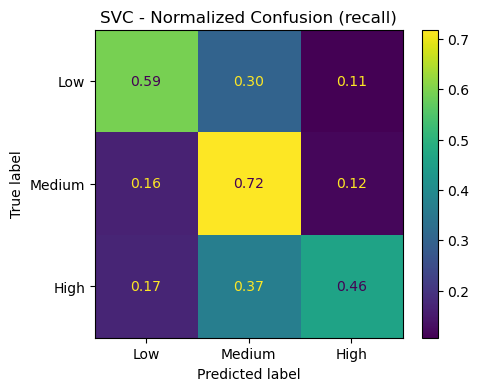


 All model results saved in ./models/


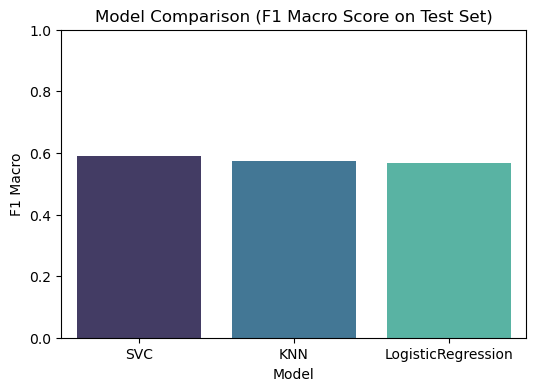

In [32]:
# 9. Evaluate models on the test set
# ---------------------------------------------------
final_reports = {}
for name, gs in results.items():
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    print(f"\n{name} - Test Accuracy: {acc:.4f} - Test F1_macro: {f1m:.4f}")
    print(classification_report(y_test, y_pred, digits=4, target_names=['Low', 'Medium', 'High']))
    plot_normalized_confusion(y_test, y_pred, labels=['Low', 'Medium', 'High'],
                              title=f'{name} - Normalized Confusion (recall)')
    final_reports[name] = {'accuracy': acc, 'f1_macro': f1m}

pd.DataFrame(final_reports).T.to_csv(MODELS_DIR / 'final_test_report.csv')
print('\n All model results saved in ./models/')

# ---------------------------------------------------
# 10. Performance summary visualization
# ---------------------------------------------------
df_results = pd.DataFrame(final_reports).T.sort_values(by='f1_macro', ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=df_results.index, y='f1_macro', data=df_results, palette='mako')
plt.title('Model Comparison (F1 Macro Score on Test Set)')
plt.ylabel('F1 Macro')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

In [ ]:
#Interpretation of results
#All three models performed similarly, with macro F1-scores around 0.56–0.59.  
#SVC gave the best overall results, suggesting it captures some nonlinear structure.  
#The Medium class was predicted most accurately, while Low and High were harder to distinguish.  
#This pattern is consistent across models and reflects overlapping feature behavior. 